<img src="https://heig-vd.ch/docs/default-source/doc-global-newsletter/2020-slim.svg" alt="Logo HEIG-VD" style="width: 80px;" align="right"/>

# Cours APN - Labo 6 : Autoencodeurs et détection de fraudes

## Résumé
Le but de ce laboratoire est d'entraîner des autoencodeurs sur des données de transactions bancaires, en mode non supervisé.  La fonction de coût sera la capacité de l'autoencodeur à reproduire en sortie les données d'entrée.  Trois réseaux de neurones autoencodeurs seront testés.

Ensuite, on considérera que les données mal reconstruites sont atypiques, et on testera l'hypothèse qu'il s'agit de transactions frauduleuses.  On utilisera donc cette information pour évaluer la capacité de l'autoencodeur à détecter les fraudes.

In [1]:
import numpy as np
import pandas as pd
import keras # pour l'installation, "pip install tensorflow" suffira

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.metrics import PrecisionRecallDisplay, average_precision_score
from sklearn.metrics import RocCurveDisplay, roc_auc_score
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Données : source

Vous utiliserez un jeu de données fourni par le [Groupe ML de l'Université Libre de Bruxelles](http://mlg.ulb.ac.be/), disponible sur Kaggle : https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud.  Pour simplifier, une version vous est fournie sur Switchdrive dans un fichier [creditcard.zip](https://drive.switch.ch/index.php/s/lBqMRsADWrU2S4R).  Voici la description des données par les auteurs :

> The dataset contains transactions made by credit cards over two days in September 2013 by European cardholders.  It contains only numerical input variables which are the result of a PCA transformation (due to confidentiality issues).  Features V1, ..., V28 are the principal components.  Two features were not transformed: 'Time' (seconds since the 1st transaction) and 'Amount'.  

> The feature 'Class' takes value 1 in case of a fraudulent transaction and 0 otherwise.  There are 492 frauds out of 284,807 transactions (0.17%).  As the dataset is highly unbalanced, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC), not with confusion matrices.

## 1. Charger et préparer les données
a. Chargez les données de `creditcard.csv` directement dans une *dataframe* Pandas appelée `data`.

In [3]:
data = pd.read_csv("data/creditcard.csv")

b. Affichez quelques informations sur ces données et leurs caractéristiques.

In [4]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


c. Construisez une nouvelle *dataframe* appelée `data_labels` contenant seulement l'attribut qui indique si une transaction est frauduleuse ou non (attribut `Class`).  Supprimez les attributs `Time` et `Class` de la *dataframe* initiale `data`.

In [5]:
data_labels = data['Class']
data.drop('Class', axis=1, inplace=True)
data.drop('Time', axis=1, inplace=True)

d. Normalisez toutes les colonnes de `data` vers des valeurs de moyenne nulle et d'écart-type égal à 1 (distribution centrée réduite). Utilisez pour cela le `StandardScaler` de scikit-learn.

In [6]:
scaler = StandardScaler()
data = scaler.fit_transform(data)

In [7]:
data

array([[-0.69424232, -0.04407492,  1.6727735 , ...,  0.33089162,
        -0.06378115,  0.24496426],
       [ 0.60849633,  0.16117592,  0.1097971 , ..., -0.02225568,
         0.04460752, -0.34247454],
       [-0.69350046, -0.81157783,  1.16946849, ..., -0.13713686,
        -0.18102083,  1.16068593],
       ...,
       [ 0.98002374, -0.18243372, -2.14320514, ...,  0.01103672,
        -0.0804672 , -0.0818393 ],
       [-0.12275539,  0.32125034,  0.46332013, ...,  0.26960398,
         0.31668678, -0.31324853],
       [-0.27233093, -0.11489898,  0.46386564, ..., -0.00598394,
         0.04134999,  0.51435531]])

e. Pourquoi est-il acceptable ici de ne pas diviser `data` en données d'entraînement et de test ?

In [11]:
labels = data_labels.value_counts()
print("Non fraude : {:.2f}%".format(labels[0] / len(data_labels) * 100))
print("Fraude : {:.2f}%".format(labels[1] / len(data_labels) * 100))


Non fraude : 99.83%
Fraude : 0.17%


Étant donné le déséquilibre marqué des données, où la classe minoritaire (fraudes) représente moins de 1 % des observations, nous utiliserons l'intégralité du dataset pour l'entraînement. Diviser les données en ensembles d'entraînement et de test risquerait de réduire encore davantage la représentation de la classe minoritaire dans l'ensemble d'entraînement, compromettant ainsi la qualité des modèles entraînés.

# 2. Définir les fonctions d'évaluation du modèle
Veuillez définir deux fonctions qui affichent :
   1. la courbe précision-rappel et la précision moyenne (qui est aussi la valeur de retour)
   1. la courbe ROC et l'aire sous la courbe (qui est aussi la valeur de retour)

Puis, veuillez recopier leur code et écrire une fonction qui affiche les deux courbes ensemble.

Ces fonctions, spécifiées ci-dessous, utilisent les classes et fonctions importées de `sklearn.metrics` au début de ce notebook.  Veuillez consulter leur documentation pour savoir comment les utiliser.

Une fonction auxiliaire vous est donnée, qui mesure l'erreur de reconstruction entre les données d'origine et celles reconstruites par un autoencodeur.

In [12]:
def reconstruction_error(X_orig, X_pred):
    '''
    Mesure l'erreur de reconstruction pour l'ensemble des données (compare 2 dataframes).
    Retourne une série avec l'erreur de chaque point de données.
    '''
    loss = np.sum((np.array(X_orig) - np.array(X_pred))**2, axis=1) # carré de l'erreur pour chaque item
    loss = pd.Series(data = loss, index = X_orig.index) # transformer en Series
    loss = (loss - np.min(loss)) / (np.max(loss) - np.min(loss)) # normalisation sur tous les items vers [0, 1]
    return loss

Veuillez écrire une fonction pour afficher la courbe précision-rappel et retourner la précision moyenne.  Veuillez écrire une fonction pour afficher la courbe ROC.  Enfin, veuillez copier le code dans une fonction qui affiche les deux courbes ensemble.  Les paramètres des fonctions sont les étiquettes correctes, les valeurs des erreurs de reconstruction, et en option les valeurs prédites par une méthode baseline, affichant ainsi deux courbes si elles sont fournies.  Leurs valeurs de retour sont respectivement la précision moyenne et l'aire sous la courbe ROC.

In [13]:
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc

In [14]:
def display_pr_curve(labels, rec_errors, baseline=[]):
    display = PrecisionRecallDisplay.from_predictions(
        labels, rec_errors, name=f'Précision moyenne = {precision_moyenne:.2f}'
    )
    plt.title('Courbe Précision-Rappel')
    plt.grid(True)
    plt.show()
    
    return precision_moyenne


In [15]:
def display_roc_curve(labels, rec_errors, baseline=[]):
    auc = roc_auc_score(labels, rec_errors)
    display = RocCurveDisplay.from_predictions(
        labels, rec_errors, name=f'AUC = {auc:.2f}'
    )
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Aléatoire')
    plt.title('Courbe ROC')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    return auc

In [16]:
def display_pr_roc(labels, rec_errors, baseline=[]):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Courbe Précision-Rappel
    PrecisionRecallDisplay.from_predictions(
        labels, rec_errors, ax=ax1, name='Précision-Rappel'
    )
    ax1.set_title('Courbe Précision Rappel')
    ax1.grid(True)
    
    # Courbe ROC
    RocCurveDisplay.from_predictions(
        labels, rec_errors, ax=ax2, name='ROC'
    )
    ax2.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Aléatoire')
    ax2.set_title('Courbe ROC')
    ax2.grid(True)
    
    plt.show()


## 3. Tester des modèles *baseline*

On considère deux modèles *baseline* pour des valeurs de reconstruction:
   1. des scores aléatoires dans [0, 1] pour chaque item : `np.random.rand(data.shape[0])`
   1. la norme L2 du vecteur d'attributs de chaque transaction, normalisée par colonne entre 0 et 1, qui peut être obtenue simplement ainsi avec la fonction définie plus haut : `reconstruction_error(data, np.zeros(data.shape[0]))`
   
Veuillez afficher les courbes précision-rappel et ROC pour ces deux *baselines* en même temps, grâce à la fonction précédente.

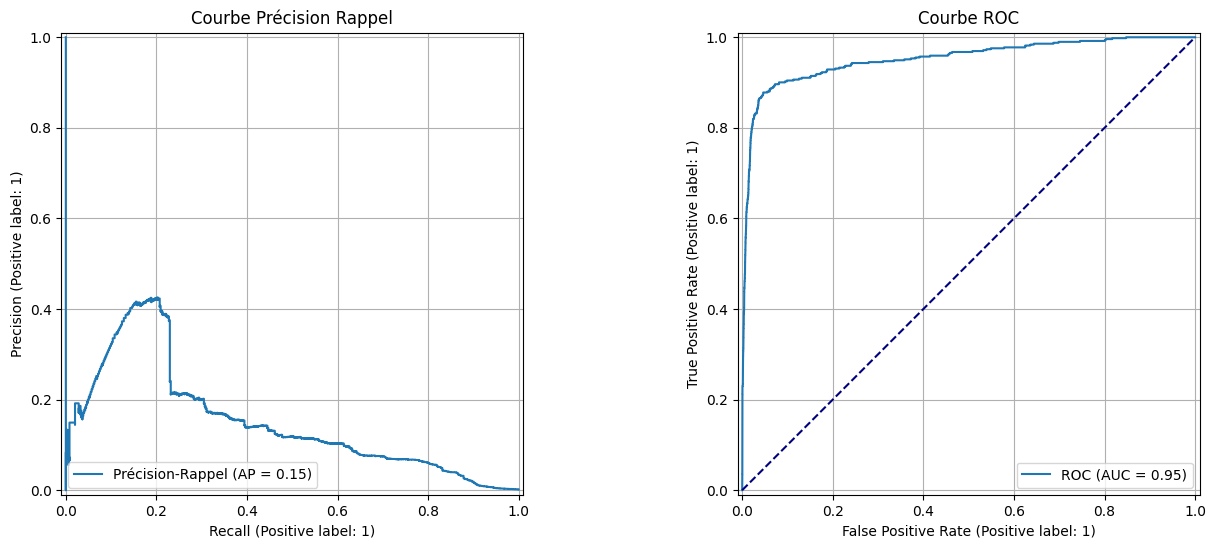

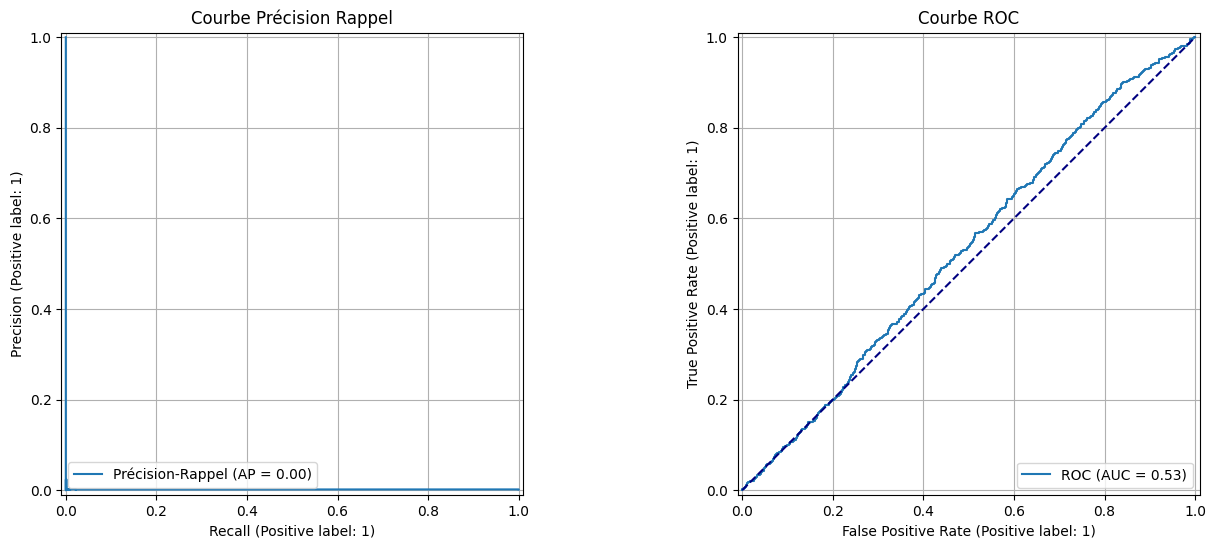

In [17]:
#Baseline 1 : Scores aléatoires dans [0, 1]
baseline_random_scores = np.random.rand(data.shape[0])

#Baseline 2 : Norme L2 des attributs (comparée à un vecteur nul)
baseline_l2_scores = reconstruction_error(pd.DataFrame(data), np.zeros(data.shape))
display_pr_roc(data_labels, baseline_l2_scores, baseline=baseline_random_scores)
display_pr_roc(data_labels, baseline_random_scores, baseline=baseline_l2_scores)

Sachant que les données proviennent d'une transformation PCA des données de transaction originales (auxquelles nous n'avons pas accès), pouvez-vous tenter d'expliquer le score non-nul obtenu par la 2e baseline ?

In [ ]:
# vu que le dataset contient beaucoup de classes 02. Calcul de la norme L2 :
#La norme L2 calcule la distance euclidienne entre chaque point de données et l'origine (dans ce cas un vecteur nul).

#Cela revient à mesurer la "longueur" de chaque vecteur représentant une transaction.
#Dans le cadre de données transformées par PCA, cette mesure capte une notion générale de complexité ou de dispersion des transactions.


#Le score non-nul de la 2e baseline (norme L2) est expliqué par plusieurs facteurs :

#Variance capturée : Même dans les données transformées par PCA, les transactions frauduleuses peuvent présenter une structure distincte en termes de variance.
#Répartition asymétrique des anomalies : La fraude peut se traduire par des distances plus grandes par rapport à des transactions normales. La norme L2 capte donc cette séparation partielle.
#Réduction de bruit : La PCA filtre une partie du bruit, laissant des signaux exploitables, que la norme L2 pourrait identifier.


#Le score obtenu montre que même un modèle très simple, comme la norme L2, peut avoir un certain pouvoir prédictif sur des données transformées par PCA. 
#Il ne s'agit pas d'un hasard, mais plutôt d'une preuve que la fraude modifie la distribution des attributs des transactions, ce que la norme L2 peut détecter partiellement.
#Cependant, le score reste faible, indiquant que des modèles plus sophistiqués sont nécessaires pour une meilleure détection.

Le score non-nul obtenu par la 2e baseline (norme L2) peut être attribué à la manière dont les données transformées par PCA capturent la variance. La PCA conserve les dimensions les plus significatives en termes de variance, ce qui permet de préserver les caractéristiques distinctives des transactions frauduleuses. Ces transactions, étant structurellement différentes des transactions normales, peuvent se situer à des distances L2 plus importantes ou avoir une répartition distincte dans l'espace transformé. En mesurant la distance euclidienne par rapport à l'origine (vecteur nul), la norme L2 capte ainsi une partie de cette séparation naturelle.

De plus, la PCA réduit le bruit des données initiales, mettant en avant des signaux exploitables, même pour des métriques simples comme la norme L2. Les fraudes, souvent associées à des comportements atypiques, apparaissent partiellement séparées des transactions normales, ce qui explique le score non-nul de cette baseline. Cependant, ce score reste limité, indiquant que la norme L2, bien qu'efficace pour capturer une partie des anomalies, ne suffit pas pour une détection complète. Cela souligne la nécessité de modèles plus complexes pour exploiter pleinement la structure sous-jacente des données et améliorer les performances.

## 4. Définir des fonctions pour entraîner, valider, et évaluer des modèles

Veuillez définir une fonction `train` qui entraîne un *modèle* (que vous créerez plus bas avec Keras) sur un jeu de *données*, avec l'objectif de reconstruire les données (donc les données d'entrée et de sortie pour un entraînement supervisé sont identiques).  Toutes les *x* époques d'entraînement (`epochs_per_iteration`) la fonction `train` affiche les scores de *précision moyenne* et de *aire sous la courbe ROC*, mais pas les graphiques.  La fonction itère cela *y* fois (`nb_iterations`).

Veuillez définir aussi une fonction `evaluate` qui affiche les courbes précision-rappel et ROC pour un modèle, et inclut dans chaque graphique la *baseline* de la norme L2 des données initiales (2e baseline de la section 3).

Vous pouvez utiliser ces [méthodes de Keras](https://keras.io/api/models/model_training_apis) :
   * [model.fit(...)](https://keras.io/api/models/model_training_apis/#fit-method) pour lancer un certain nombre de pas d'entraînement (*backward pass*)
   * [model.predict(...)](https://keras.io/api/models/model_training_apis/#predict-method) pour exécuter le modèle sur des données et obtenir la sortie (*forward pass*)

In [18]:
def train(model, data, epochs_per_iteration = 10, nb_iterations = 10):
    # Initialisation de la variable pour suivre les scores
    for iteration in range(nb_iterations):
        print(f"Iteration {iteration + 1}/{nb_iterations}")
        
        # Entraînement du modèle sur les données
        model.fit(data, data, epochs=epochs_per_iteration, batch_size=32, verbose=1)
        
        # Prédictions du modèle
        reconstructed_data = model.predict(data)
        
        # Calcul de l'erreur de reconstruction
        rec_errors = reconstruction_error(pd.DataFrame(data), reconstructed_data)
        
        # Calcul de la précision moyenne (AP) et de l'AUC
        ap_score = average_precision_score(data_labels, rec_errors)
        auc_score = roc_auc_score(data_labels, rec_errors)
        
        # Affichage des scores
        print(f"Précision Moyenne (AP) : {ap_score:.4f}")
        print(f"Aire Sous la Courbe ROC (AUC) : {auc_score:.4f}")
        
        # Ajouter un petit espace pour la lisibilité
        print("\n")

In [19]:
def evaluate(model, data, data_labels):
    # Prédictions du modèle (reconstruction des données)
    reconstructed_data = model.predict(data)
    
    # Calcul de l'erreur de reconstruction (comme la différence entre les données originales et reconstruites)
    rec_errors = reconstruction_error(pd.DataFrame(data), reconstructed_data)
    
    # Baseline : norme L2 des données (comme mentionné dans la section précédente)
    baseline_l2_scores = reconstruction_error(pd.DataFrame(data), np.zeros(data.shape))
    
    # Affichage des courbes Precision-Recall et ROC
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # 1. Courbe Précision-Rappel
    PrecisionRecallDisplay.from_predictions(
        data_labels, rec_errors, ax=ax1, name='Modèle (Précision-Rappel)'
    )
    # Ajouter la baseline L2 sur la même courbe
    PrecisionRecallDisplay.from_predictions(
        data_labels, baseline_l2_scores, ax=ax1, name='Baseline L2', color='orange', linestyle='--'
    )
    ax1.set_title('Courbe Précision-Rappel')
    ax1.grid(True)

    # 2. Courbe ROC
    RocCurveDisplay.from_predictions(
        data_labels, rec_errors, ax=ax2, name='Modèle (ROC)'
    )
    # Ajouter la baseline L2 sur la même courbe
    RocCurveDisplay.from_predictions(
        data_labels, baseline_l2_scores, ax=ax2, name='Baseline L2', color='orange', linestyle='--'
    )
    ax2.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Aléatoire')
    ax2.set_title('Courbe ROC')
    ax2.grid(True)
    
    # Afficher les courbes
    plt.show()

## 5. Créer, entraîner et évaluer des autoencodeurs 

### 5.1. Autoencodeur simple à trois couches

Veuillez définir en Keras un autoencodeur à trois couches, avec une couche de codage ayant une dimension plus faible que celle d'entrée (*undercomplete autoencoder*).  Utiliser un modèle de type `Sequential()` avec des couches entièrement connectées de type `Dense()`, en vous guidant sur les [exemples de Keras](https://keras.io/api/models/sequential/).  Choisissez une fonction de coût (*loss*) et un optimiseur appropriés.  N'oubliez pas de [compiler le modèle](https://keras.io/api/models/model_training_apis/#compile-method) à la fin.

In [38]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam

def create_autoencoder(input_dim):
    
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(16, activation='relu')(input_layer)
    decoded = Dense(input_dim, activation='linear')(encoded)
    
    autoencoder = Model(inputs=input_layer, outputs=decoded)
    autoencoder.compile(optimizer=Adam(), loss='mean_squared_error')
    
    return autoencoder


In [39]:
model = create_autoencoder(data.shape[1])
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 29)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 29)             │           493 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 973 (3.80 KB)

 Trainable params: 973 (3.80 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# model.save('modele_1.h5')  # enregistrer le modèle
# del model  # supprimer le modèle de la mémoire
# model = keras.models.load_model('modele_1.h5') # charger le modèle

Veuillez entraîner le modèle avec la fonction `train` que vous avez définie plus haut.  Selon vos résultats intermédiaires, écrivez ici la commande qui semble suffisante pour atteindre le maximum de performance, et affichez ses résultats.  Notez que le modèle est sauvegardé, donc plusieurs appels à `train` permettent de continuer l'entraînement.  Dans votre rapport final, indiquez explicitement la durée totale en nombre d'époques.

In [ ]:
# J'ai choisi le nombre d'époque à 4 car avec plus de 4 époques, les améliorations sont minimes et ça ralentit l'entrainement
train(model, data, 6, 10)

Iteration 1/10
Epoch 1/6
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 8s 931us/step - loss: 0.4323
Epoch 2/6
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 8s 941us/step - loss: 0.4161
Epoch 3/6
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 8s 926us/step - loss: 0.4113
Epoch 4/6
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 8s 937us/step - loss: 0.4150
Epoch 5/6
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 9s 976us/step - loss: 0.4075
Epoch 6/6
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 9s 966us/step - loss: 0.4128
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 5s 515us/step
Précision Moyenne (AP) : 0.1333
Aire Sous la Courbe ROC (AUC) : 0.9512


Iteration 2/10
Epoch 1/6
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 8s 861us/step - loss: 0.4137
Epoch 2/6
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 8s 857us/step - loss: 0.4132
Epoch 3/6
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 8s 890us/step - loss: 0.4039
Epoch 4/6
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 8s 858us/step - loss: 0.4252
Epoch 5/6
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 8s 872us/step - loss: 0.4258
Epoch 6/6
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 8s 866us/step - loss: 0.4240
8901/8901 ━━

Veuillez afficher les deux courbes (y compris les *baselines*), et les scores du modèle avec la fonction `evaluate`.

8901/8901 ━━━━━━━━━━━━━━━━━━━━ 5s 559us/step


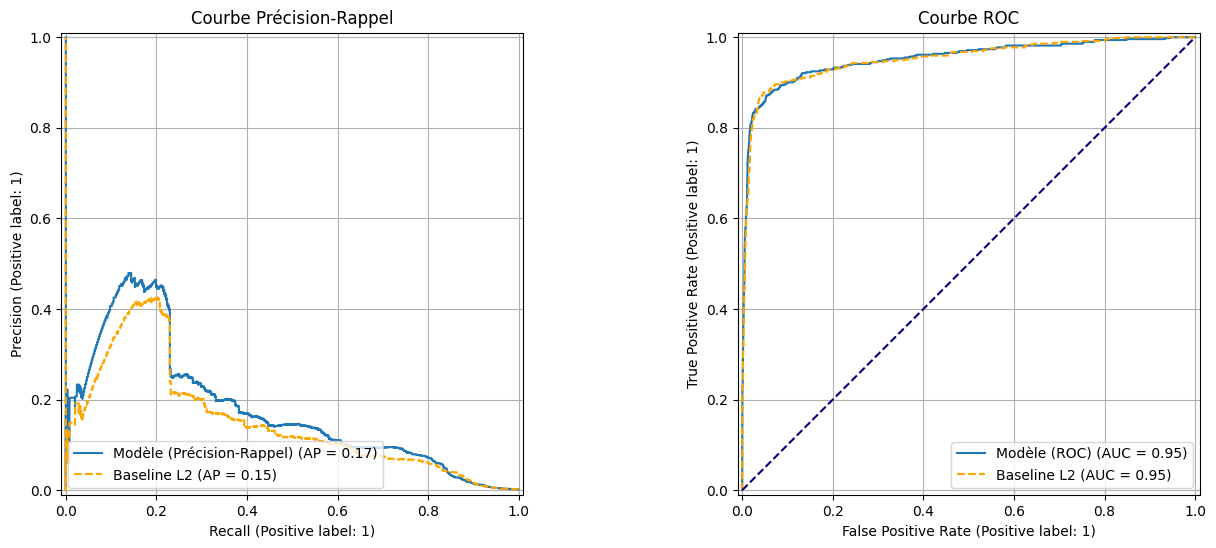

In [45]:
evaluate(model, data, data_labels)

**Veuillez discuter vos résultats.**  Comment jugez-vous la capacité du modèle à détecter des transactions frauduleuses, compte tenu du fait qu'il n'a jamais été entraîné de manière supervisée ?  Comment se compare-t-il avec la baseline ?  Quelle est sa précision maximale, et pour quel rappel est-elle atteinte ?  (Approximativement, d'après le graphique.)  Comment interprétez-vous ces valeurs ?

Le modèle montre une capacité intéressante à détecter les transactions frauduleuses, même sans avoir été entraîné de manière supervisée. Cela s’explique par son apprentissage des données normales : les fraudes, qui sont des anomalies, sont moins bien reconstruites, ce qui entraîne des erreurs de reconstruction plus élevées. Par rapport à la baseline L2, qui calcule simplement la distance euclidienne dans l’espace PCA, le modèle se montre légèrement plus performant avec une précision moyenne (AP) de 0.17 contre 0.15 pour la baseline. Cela prouve qu’il capte des signaux supplémentaires liés aux anomalies.

Cependant, si l’on regarde les courbes Précision-Rappel et ROC, les limites du modèle apparaissent clairement. Bien que l’AUC ROC soit élevée (0.95), tout comme celle de la baseline, le modèle atteint une précision maximale d’environ 0.5 pour un rappel très faible (∼18%). Cela signifie que lorsqu’il détecte des fraudes, il est précis une fois sur deux, mais il passe à côté de la majorité ( 92 %) des fraudes vu que le rappel est d'environ 18%. Cela reflète les limites d’un entraînement purement non supervisé, qui n’exploite pas d’informations spécifiques sur les fraudes.

En conclusion, bien que ce modèle soit légèrement meilleur que la baseline, il reste limité pour détecter efficacement toutes les fraudes. Il est capable d’identifier certaines anomalies, mais il n'est pas capable de détecter la majorité des fraudes.

### 5.2. Autoencodeur à cinq couches

Veuillez définir maintenant un autoencodeur à cinq couches, sur le même principe que le précédent, toujours *undercomplete*.  Effectuez son entraînement et son évaluation finale, comme pour le modèle à 3 couches.

In [86]:
def create_autoencoder_5_layers(input_dim):
    
    input_layer = Input(shape=(input_dim,))
    
    hiden_layer1 = Dense(16, activation='linear')(input_layer)
    hiden_layer2 = Dense(8, activation='linear')(hiden_layer1) # pas utilsé relu car l'erreur de reconstruction est plsu grande
    hiden_layer3 = Dense(16, activation='linear')(hiden_layer2)

    output_layer = Dense(input_dim, activation='linear')(hiden_layer3)
    
    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    autoencoder.compile(optimizer=Adam(), loss='mean_squared_error')
    
    return autoencoder

In [87]:
model2 = create_autoencoder_5_layers(data.shape[1])
model2.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 29)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 16)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 29)             │           493 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,253 (4.89 KB)

 Trainable params: 1,253 (4.89 KB)

 Non-trainable params: 0 (0.00 B)

In [88]:
# train(model2, data, 6, 10)
train(model2, data, 6, 10)

Iteration 1/10
Epoch 1/6
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - loss: 0.7511
Epoch 2/6
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 0.6998
Epoch 3/6
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 0.6938
Epoch 4/6
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 0.6838
Epoch 5/6
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 0.6917
Epoch 6/6
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - loss: 0.6923
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 6s 647us/step
Précision Moyenne (AP) : 0.1750
Aire Sous la Courbe ROC (AUC) : 0.9558


Iteration 2/10
Epoch 1/6
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 0.6887
Epoch 2/6
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - loss: 0.6886
Epoch 3/6
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 0.6885
Epoch 4/6
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.6921
Epoch 5/6
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 0.7012
Epoch 6/6
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - loss: 0.6934
8901/8901 ━━━━━━━━━━━━━━━

In [ ]:
#model.save('modele_2.h5')  # enregistrer le modèle
# del model  # supprimer le modèle de la mémoire
# model = keras.models.load_model('modele_1.h5') # charger le modèle

8901/8901 ━━━━━━━━━━━━━━━━━━━━ 6s 656us/step


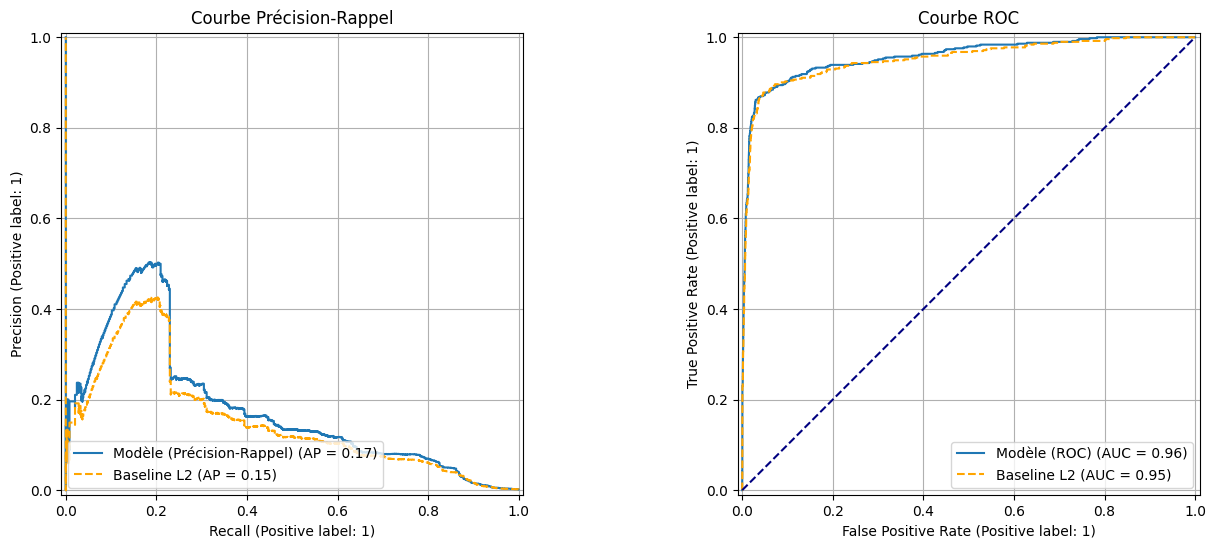

In [89]:
evaluate(model2, data, data_labels)

Veuillez discuter vos résultats et les comparer avec les précédents.

Le modèle à 5 couches montre des performances globales similaires à celles du modèle précédent à 3 couches, avec une précision moyenne (AP) de 0.17 et une AUC ROC de 0.95. Ces résultats indiquent que le modèle parvient à capturer une partie des relations présentes dans les données et à distinguer les transactions normales des anomalies. L’utilisation d’activations linéaires semble mieux adaptée aux données transformées par PCA, car cette transformation est linéaire par nature. Cela a probablement permis une meilleure reconstruction des données, tout en maintenant de bonnes performances par rapport à l’utilisation de ReLU. En effet, lors de tests avec ReLU dans les couches cachées, la précision-rappel obtenue était nettement inférieure, à seulement 0.02.

En analysant les courbes précision-rappel, on observe un comportement similaire à celui du modèle précédent. La précision maximale atteint environ 0.5, mais pour un rappel très faible (∼19%), ce qui indique que le modèle détecte efficacement une petite portion des fraudes (les plus évidentes) mais échoue à généraliser pour capturer une proportion plus importante d’anomalies. Cette limitation s’explique principalement par l’absence d’entraînement supervisé. La courbe ROC, quant à elle, reste identique pour les deux modèles, reflétant leur capacité similaire à exploiter les mêmes signaux dans les données pour distinguer les classes, mais sans dépasser la baseline L2.

Le rappel de 19% pour une précision maximale de 0.5 montre que le modèle est capable d’identifier une fraction des fraudes, mais avec une marge d’erreur élevée (la moitié des cas sont mal classés). Cela illustre ses limites pour généraliser et détecter efficacement la majorité des fraudes.

En conclusion, bien que les deux modèles soient légèrement meilleurs que la baseline et capables de détecter certaines fraudes, ils restent limités dans leur capacité à couvrir l’ensemble des anomalies. Ces résultats montrent que, bien qu’ils identifient une partie des fraudes de manière satisfaisante, ils ne parviennent pas à capturer les schémas subtils nécessaires pour détecter une majorité de fraudes. Un entraînement supervisé ou une architecture plus adaptée pourrait surmonter ces limites comme c'est le cas pour le troisième modèle qui obtient de meilleurs résultats.

### 5.3. Autoencodeur à trois couches, *overcomplete*, avec *sparsity*
Veuillez enfin définir un autoencodeur à trois couches, mais avec une couche cachée ayant une dimension supérieure à celle des couches d'entrée et de sortie.  Afin d'éviter la pure copie entrée/sortie, ajoutez une contrainte de régularisation sur la couche cachée, qui limite la somme des valeurs absolues des activations dans cette couche (voir la [documentation](https://keras.io/api/layers/regularizers/) de Keras).

In [92]:
from keras.regularizers import l1

def create_autoencoder_3_layers_reg(input_dim):
    
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(70, activation='relu', activity_regularizer=l1(1e-4))(input_layer)
    decoded = Dense(input_dim, activation='linear')(encoded)
    
    autoencoder = Model(inputs=input_layer, outputs=decoded)
    autoencoder.compile(optimizer=Adam(), loss='mean_squared_error')
    
    return autoencoder

In [93]:
model3 = create_autoencoder_3_layers_reg(data.shape[1])
model3.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 29)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 70)             │         2,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 29)             │         2,059 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,159 (16.25 KB)

 Trainable params: 4,159 (16.25 KB)

 Non-trainable params: 0 (0.00 B)

In [94]:
train(model3, data, 5, 10)

Iteration 1/10
Epoch 1/5
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - loss: 0.2049
Epoch 2/5
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.0367
Epoch 3/5
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 0.0242
Epoch 4/5
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.0193
Epoch 5/5
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 9s 971us/step - loss: 0.0173
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 5s 552us/step
Précision Moyenne (AP) : 0.0979
Aire Sous la Courbe ROC (AUC) : 0.9255


Iteration 2/10
Epoch 1/5
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 9s 953us/step - loss: 0.0193
Epoch 2/5
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 9s 997us/step - loss: 0.0178
Epoch 3/5
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 9s 980us/step - loss: 0.0171
Epoch 4/5
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.0151
Epoch 5/5
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.0156
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 9s 991us/step
Précision Moyenne (AP) : 0.3661
Aire Sous la Courbe ROC (AUC) : 0.9436


Iteration 3/10
Epoch 1/5
8901/8901 ━━━━━━━━━

In [ ]:
# model.save('modele_3.h5')  # enregistrer le modèle
# del model  # supprimer le modèle de la mémoire
# model = keras.models.load_model('modele_1.h5') # charger le modèle

8901/8901 ━━━━━━━━━━━━━━━━━━━━ 6s 640us/step


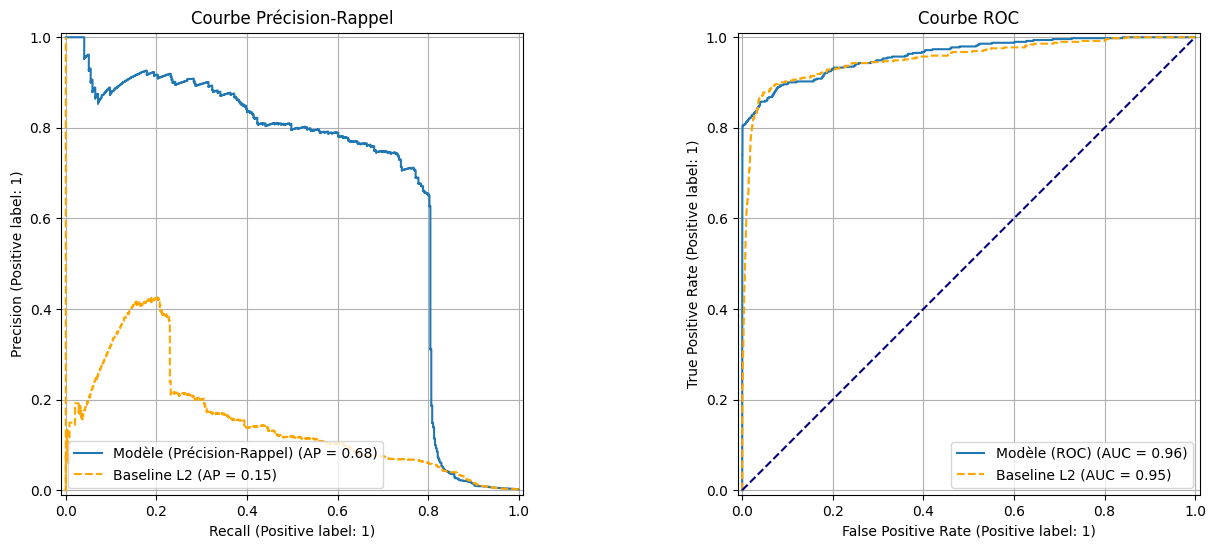

In [95]:
evaluate(model3, data, data_labels)

### Note : 
Ces résultats ont été obtenus en relançant plusieurs fois les entraînements, et en ajustant les hyperparamètres.  Les résultats peuvent varier d'une exécution à l'autre.

---

Veuillez discuter vos résultats et les comparer avec les précédents.

Le troisième modèle, qui utilise un auto encodeur sur-complet à 3 couches avec une régularisation L1, montre une amélioration marquante par rapport aux modèles précédents. Il atteint une précision moyenne (AP) de 0.68, bien supérieure aux AP de 0.17 obtenues avec les modèles précédents. L’ajout de la régularisation L1 aide le modèle à se concentrer sur les dimensions les plus pertinentes des données transformées par PCA, tout en réduisant l’impact du bruit. Cela lui permet de mieux identifier les anomalies, en particulier les transactions frauduleuses, tout en améliorant la généralisation.

En observant les courbes Précision-Rappel, on constate une nette amélioration. Contrairement aux modèles précédents où la précision chutait rapidement après un faible rappel (∼20%), ce modèle maintient une précision élevée (∼0.8) sur une large plage de rappel. Cela montre qu’il est capable de couvrir une proportion beaucoup plus importante des fraudes sans compromettre significativement la précision. La courbe ROC, avec une AUC de 0.96, est légèrement meilleure que celle des modèles précédents (AUC = 0.95), confirmant une meilleure gestion des faux positifs tout en maximisant les vrais positifs.

## Conclusion :

En conclusion, le troisième modèle surpasse nettement les précédents grâce à sa régularisation L1 et à son architecture d'autoencodeur surcomplet (avec plus de neurones dans la couche cachée que d'entrées). Ces résultats montrent que l’ajout de neurones supplémentaires, combiné à une régularisation bien ajustée, permet une meilleure détection des anomalies dans des données déséquilibrées. Cela souligne l’importance de la régularisation pour éviter le surajustement et améliorer la généralisation lors qu'on augmente la complexité du modèle.

De plus, on observe que les autoencodeurs sous-complets (avec moins de neurones dans les couches cachées que d'entrées) peinent à capturer toutes les informations pertinentes lorsque les données ont déjà été réduites en dimensionnalité, comme dans le cas de l'application préalable de la PCA. En revanche, les autoencodeurs surcomplets sont mieux adaptés à ce type de données, car ils offrent une capacité supplémentaire pour reconstruire les informations importantes tout en bénéficiant de la régularisation pour éviter le surajustement.

Pour aller plus loin, il serait intéressant d’expérimenter avec d’autres formes de régularisation, comme le Dropout, et d’ajuster les hyperparamètres, notamment le coefficient de régularisation, afin d’affiner encore les performances. Ces ajustements pourraient renforcer la capacité du modèle à généraliser et à détecter les anomalies les plus subtiles

### Fin du laboratoire 6
Veuillez nettoyer le *notebook* et y inclure l'affichage des résultats de vos systèmes définitifs.  Ne pas effacer les logs d'entraînement et les graphiques.  Veuillez ensuite soumettre le *notebook* sur Cyberlearn.